# Further investigation after one round of embedding and clustering

After using two internal clustering metrics, we don't see any strong evidence for a particular number of k-means clusters for any value of k from 4 to 19. HDBSCAN with default parameters returned a very large number of clusters (~150),  with > 90% of sentences being unclassified. 


In [1]:
%config Completer.use_jedi = False

import os
from datetime import datetime
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sparknlp
print(f"SparkNLP version: {sparknlp.version()}")
import pyspark.sql.functions as F
from pyspark.sql import types as T
from sparknlp.base import LightPipeline

import tensorflow as tf
import tensorflow_hub as hub
# this is needed to use some hub modules
import tensorflow_text as tftext
print(f"Tensorflow version: {tf.__version__}")

try:
    import plotly
except ImportError as e:
    ! pip install plotly==4.14.3
    import plotly
import plotly.express as px
print(f"Plotly version: {plotly.__version__}")

DATA_PATH = "../data/reddit_wsb.csv"

# Spark NLP requires Java 8
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk"
os.environ["PATH"] = f"{os.environ['JAVA_HOME']}/bin:{os.environ['PATH']}"

# to allow importing from parent directory of notebooks folder
sys.path.append('..')

spark = sparknlp.start()

%load_ext autoreload
%autoreload 1
%aimport embedding_pipeline

SparkNLP version: 2.7.4
Tensorflow version: 2.4.1
Plotly version: 4.14.3


## Read the data

In [2]:
%%time
# read the data frame
df = spark.read.csv(DATA_PATH, 
                    header=True,
                    multiLine=True,
                    inferSchema=True,
                    quote="\"",
                    escape="\"")

# # for dev purposes
# df = df.sample(withReplacement=False, fraction=0.01, seed=1)

# concatenate both text columns. drop everything but id
df = (df.withColumn("text", 
               F.concat_ws(". ", df.title, df.body))
      .select("id", "text"))
print(df)

# i could just rename df, but I do this to avoid unforeseen conflicts
full_len_df = df.select("id", "text", F.length(F.col("text")).alias('length'))

DataFrame[id: string, text: string]
CPU times: user 6.08 ms, sys: 2.78 ms, total: 8.86 ms
Wall time: 4.71 s


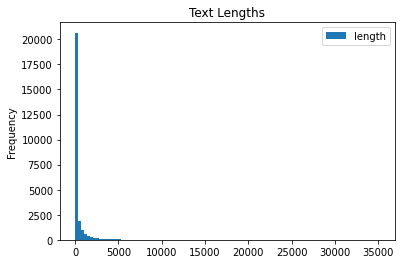

In [3]:
lengths = full_len_df.select("length")
pddf = lengths.toPandas()
axes = pddf.plot(title="Text Lengths",
                 kind="hist",
                 **{"bins":100})

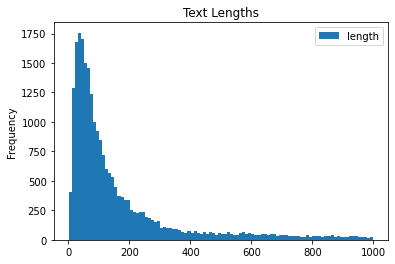

In [21]:
qpddf = pddf.query("length<1000")
axes = qpddf.plot(title="Text Lengths",
                 kind="hist",
                 **{"bins":100})

In [46]:
short_texts = full_len_df.select("text").where(F.col("length") < 100)
short_texts.show(100, truncate=120)
short_texts.count()

+--------------------------------------------------------------------------------------------------+
|                                                                                              text|
+--------------------------------------------------------------------------------------------------+
|                                    It's not about the money, it's about sending a message. 🚀💎🙌|
|                  Math Professor Scott Steiner says the numbers spell DISASTER for Gamestop shorts|
|                       NEW SEC FILING FOR GME! CAN SOMEONE LESS RETARDED THAN ME PLEASE INTERPRET?|
|                   Not to distract from GME, just thought our AMC brothers should be aware of this|
|                                                                               WE BREAKING THROUGH|
|    Currently Holding AMC and NOK - Is it retarded that I think I should move it all to GME today?|
|                         I have nothing to say but BRUH I am speechless TO THE MOON 🚀🚀🚀💎💎👋👋|


12869

# Process with SparkNLP and SQL 1
Process texts of all lengths.

In [5]:
# preprocess texts with Spark NLP pipeline
texts = (
    embedding_pipeline.preprocess_texts(df)
)

# get pipeline
pipeline = embedding_pipeline.build_embedding_preproc_pipeline()
pipeline_model = pipeline.fit(texts)
light_model = LightPipeline(pipeline_model)

# transform texts
%time short_sentences = light_model.transform(texts)
print(f"Processed (and counted) {df.count()} rows.")

# register new data frame as a table so I can
# run more complex SQL queries against it.
short_sentences.registerTempTable("short_sents")

CPU times: user 14 ms, sys: 5.42 ms, total: 19.4 ms
Wall time: 337 ms
Processed (and counted) 25647 rows.


In [6]:
%%time
# the sentences are often rather short, so we now concatenate
# some of them together up to a length. here we choose it to be close to
# but short of the max_seq_length (128) of the USE model we are using,
# but one should experiment and fine tune this parameter

# define function for counting spaces
spark.udf.register("count_spaces", lambda s: s.count(" "))

# this will limit the lengths of our longer output 'sentences'
trunc_len=100

ddf = spark.sql(f"""
/* do basic naming/recasting and count spaces as approximation
   of number of tokens in seq length. */

WITH cte1 AS  
(SELECT id AS post_id,
        CAST(finished_sentences_metadata[0]._2 AS INTEGER) AS sent_num,
        count_spaces(finished_sentences[0]) AS space_count,
        finished_sentences[0] as short_sent
FROM short_sents),

/* sum number of spaces within group and divide by trunc length.
   this gives an imperfect but simple, usable and quick-to-compute 
   index tellilng us when to start concatenating a new group. Note 
   that, chunk nums could increase as in 0, 1, 3, due to a long
   'short_sent', but we fixt that using ROW_NUMBER() in the next
   query.*/
   
     cte2 AS 
(SELECT post_id,
        CAST((SUM(space_count) 
                OVER (PARTITION BY post_id ORDER BY sent_num)
            )/{trunc_len} AS INTEGER)
        AS chunk_num,
        short_sent FROM cte1)

/* now concatenate along chunk_num. */

SELECT  post_id,
        (ROW_NUMBER() OVER (PARTITION BY post_id ORDER BY chunk_num))-1 
        AS chunk_num,
        CONCAT_WS(" ", COLLECT_LIST(short_sent)) AS long_sent
FROM cte2
GROUP BY post_id, chunk_num
""")

ddf.registerTempTable("long_sents")

CPU times: user 11.3 ms, sys: 6.12 ms, total: 17.4 ms
Wall time: 475 ms


In [7]:
%%time
ddf.show(truncate=80)
print(f"Number of rows: {ddf.count()}")

+-------+---------+--------------------------------------------------------------------------------+
|post_id|chunk_num|                                                                       long_sent|
+-------+---------+--------------------------------------------------------------------------------+
| l6pxtl|        0|                                    The Tendie defender is here to hold GME open|
| l6wugo|        0|                                                                          MTNB ?|
| l6wx2j|        0|                                          Robinhood not allowing purchase of AMC|
| l6wydu|        0|It seems as though Robinhood is blocking people from buying additional shares...|
| l6wzmx|        0|RH is no longer supporting GME! Although I am not on his , I am still having ...|
| l6yvik|        0|Too late?. Have I missed the bandwagon and is it best to buy GME or AMC if I do?|
| l6yvkf|        0|     WE BROKE SCHWAB. The trading system is unavailable. Please try agai

In [8]:
len_df = spark.sql("""
WITH cte AS 
    (SELECT LENGTH(long_sent) 
     AS len FROM long_sents)
SELECT len
FROM cte
ORDER BY len
""")
desc = len_df.describe()
desc.show()

+-------+-----------------+
|summary|              len|
+-------+-----------------+
|  count|            34505|
|   mean|254.4965367338067|
| stddev| 228.518156678462|
|    min|                3|
|    max|             3276|
+-------+-----------------+



The distribution is bimodal:

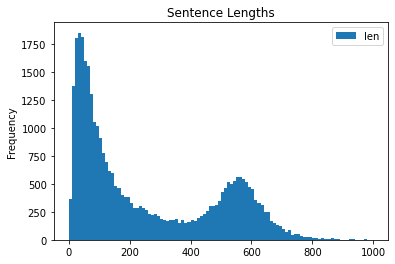

In [9]:
pddf = len_df.toPandas()
axes = pddf.plot(title="Sentence Lengths",
                 kind="hist",
                 **{"bins":100, 
                    "range":(0,1000)})

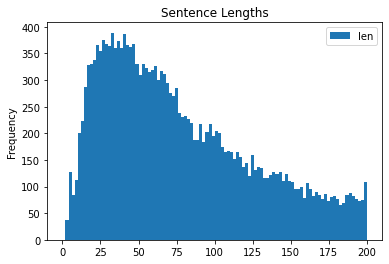

In [10]:
axes = pddf.plot(title="Sentence Lengths",
                 kind="hist",
                 **{"bins":100, 
                    "range":(0,200)})

In [6]:
%%time
day, time = str(datetime.now()).split()
time = time.split(".")[0]
timestamp = "_".join([day, time])
OUTPUT_DIR = f"../data/sentences_{timestamp}"
ddf.coalesce(1).write.csv(OUTPUT_DIR, header=True, sep="\t")
print(f"Wrote csv file inside {OUTPUT_DIR}")

Wrote csv file inside ../data/sentences_2021-03-05_10:36:08
CPU times: user 2.23 ms, sys: 3.23 ms, total: 5.46 ms
Wall time: 35.1 s


# Process with SparkNLP and SQL 2
Process only texts greater than some length. Here we set ``df = full_len_df.where(F.col("length") > 100)``.

In [4]:
df = full_len_df.where(F.col("length") > 100)

# preprocess texts with Spark NLP pipeline
texts = (
    embedding_pipeline.preprocess_texts(df)
)

# get pipeline
pipeline = embedding_pipeline.build_embedding_preproc_pipeline()
pipeline_model = pipeline.fit(texts)
light_model = LightPipeline(pipeline_model)

# transform texts
%time short_sentences = light_model.transform(texts)
print(f"Processed (and counted) {df.count()} rows.")

# register new data frame as a table so I can
# run more complex SQL queries against it.
short_sentences.registerTempTable("short_sents")

CPU times: user 14.8 ms, sys: 3.54 ms, total: 18.4 ms
Wall time: 390 ms
Processed (and counted) 12691 rows.


In [5]:
%%time
# the sentences are often rather short, so we now concatenate
# some of them together up to a length. here we choose it to be close to
# but short of the max_seq_length (128) of the USE model we are using,
# but one should experiment and fine tune this parameter

# define function for counting spaces
spark.udf.register("count_spaces", lambda s: s.count(" "))

# this will limit the lengths of our longer output 'sentences'
trunc_len=100

ddf = spark.sql(f"""
/* do basic naming/recasting and count spaces as approximation
   of number of tokens in seq length. */

WITH cte1 AS  
(SELECT id AS post_id,
        CAST(finished_sentences_metadata[0]._2 AS INTEGER) AS sent_num,
        count_spaces(finished_sentences[0]) AS space_count,
        finished_sentences[0] as short_sent
FROM short_sents),

/* sum number of spaces within group and divide by trunc length.
   this gives an imperfect but simple, usable and quick-to-compute 
   index tellilng us when to start concatenating a new group. Note 
   that, chunk nums could increase as in 0, 1, 3, due to a long
   'short_sent', but we fixt that using ROW_NUMBER() in the next
   query.*/
   
     cte2 AS 
(SELECT post_id,
        CAST((SUM(space_count) 
                OVER (PARTITION BY post_id ORDER BY sent_num)
            )/{trunc_len} AS INTEGER)
        AS chunk_num,
        short_sent FROM cte1)

/* now concatenate along chunk_num. */

SELECT  post_id,
        (ROW_NUMBER() OVER (PARTITION BY post_id ORDER BY chunk_num))-1 
        AS chunk_num,
        CONCAT_WS(" ", COLLECT_LIST(short_sent)) AS long_sent
FROM cte2
GROUP BY post_id, chunk_num
""")

ddf.registerTempTable("long_sents")

CPU times: user 9.38 ms, sys: 3.31 ms, total: 12.7 ms
Wall time: 553 ms


In [6]:
%%time
ddf.show(truncate=80)
print(f"Number of rows: {ddf.count()}")

+-------+---------+--------------------------------------------------------------------------------+
|post_id|chunk_num|                                                                       long_sent|
+-------+---------+--------------------------------------------------------------------------------+
| l6wydu|        0|It seems as though Robinhood is blocking people from buying additional shares...|
| l6wzmx|        0|RH is no longer supporting GME! Although I am not on his , I am still having ...|
| l6yw6k|        0|Redditors of WSB we "WILL" change the world NOW let's GET BB TO PLUTO . We al...|
| l6yw9q|        0|                   Let's $PLAY with some more Hedge Fund Moneeey. $PLAY babyyyy.|
| l6ywcd|        0|Entered at $390 let's go boys . Bought some shares at $390 right after openin...|
| l6yyv2|        0|Can someone dumb down and explain what's happening right now and how things w...|
| l6yza1|        0|Time to jump ship from Robinhood. With the shit RH is pulling right now,

In [12]:
ddf = spark.sql("""
    SELECT *, 
    LENGTH(long_sent) 
        AS len 
    FROM long_sents
""")

In [15]:
len_df = ddf.select("len")
desc = len_df.describe()
desc.show()

+-------+------------------+
|summary|               len|
+-------+------------------+
|  count|             21627|
|   mean|377.11087991862024|
| stddev|206.57482479852607|
|    min|                 4|
|    max|              3276|
+-------+------------------+



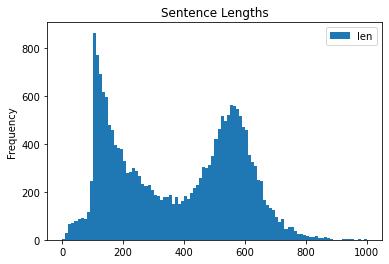

In [16]:
pddf = len_df.toPandas()
axes = pddf.plot(title="Sentence Lengths",
                 kind="hist",
                 **{"bins":100, 
                    "range":(0,1000)})

We will drop the truncated bits, which could turn into noise for our density-based clustering algorithms.

In [22]:
out_df = ddf.where("len > 100").drop("len")
out_df.count()

20694

In [24]:
20694 / 32

646.6875

In [23]:
%%time
day, time = str(datetime.now()).split()
time = time.split(".")[0]
timestamp = "_".join([day, time])
OUTPUT_DIR = f"../data/sentences_{timestamp}"
out_df.coalesce(1).write.csv(OUTPUT_DIR, header=True, sep="\t")
print(f"Wrote csv file inside {OUTPUT_DIR}")

Wrote csv file inside ../data/sentences_2021-03-07_12:45:54
CPU times: user 4.64 ms, sys: 325 µs, total: 4.97 ms
Wall time: 25.1 s


# Scratch: using petastorm for interface Spark <-> Tensorflow
Petastorm is one way to avoid outputing the cleaned data to disk and then reimporting. It writes the files to parquet and gives a fast interface to Tensorflow. In a production system, it would be better to use this framework, or to run the Tensorflow inference directly in Spark.

In [7]:
# I also looked at using TFRecords, but it seemed
# like it might be a pain to integrate the tf-spark
# connector with Spark NLP.

try:
    import petastorm
except ModuleNotFoundError:
    ! pip install petastorm==0.9.8
    import petastorm
    
from petastorm.spark import (SparkDatasetConverter, 
                             make_spark_converter)

import tensorflow.compat.v1 as tf

In [8]:
%%time
CACHE_DIR = f"{os.environ['PWD']}/data/cache/"
spark.conf.set(SparkDatasetConverter.PARENT_CACHE_DIR_URL_CONF,
               f"file://{CACHE_DIR}")
# this writes the parquet file(s)
converter = make_spark_converter(ddf)
# with this context, we have access to an object of type
# tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter
dataset_context_manager = converter.make_tf_dataset()

Converting floating-point columns to float32
The median size 47368 B (< 50 MB) of the parquet files is too small. Total size: 9622619 B. Increase the median file size by calling df.repartition(n) or df.coalesce(n), which might help improve the performance. Parquet files: file:///home/cody/data/cache/20210305105721-appid-local-1614958526738-c1b0851a-4473-45d1-a147-a63ae829e40c/part-00116-74b579b0-7e78-44b1-a92c-c68d3a146a01-c000.parquet, ...


CPU times: user 63 ms, sys: 20.1 ms, total: 83.1 ms
Wall time: 31.8 s


In [9]:
with dataset_context_manager as dataset:
    print(dataset, "\n")
    for batch in dataset.take(1):
        print(batch)

/home/cody/anaconda3/lib/python3.7/site-packages/petastorm/tf_utils.py:135: UnicodeWarning: Tensorflow will convert all unicode strings back to bytes type. You may need to decode values.
  "You may need to decode values.", UnicodeWarning)


<DatasetV1Adapter shapes: inferred_schema_view(post_id=(None,), chunk_num=(None,), long_sent=(None,)), types: inferred_schema_view(post_id=tf.string, chunk_num=tf.int32, long_sent=tf.string)> 

inferred_schema_view(post_id=<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'l6o19x', b'l6o19x', b'l6sc6m', b'l6sc6m', b'l6sc6m', b'l6t5uo',
       b'l6wwqd', b'l6wwyn', b'l6wzgz', b'l6wzgz', b'l6yw01', b'l6ywaf',
       b'l6ywrh', b'l6yy3x', b'l6yyh5', b'l6zcsr', b'l6zdqe', b'l6ze0x',
       b'l6ze9d', b'l6zeyt', b'l6zfa2', b'l6zfda', b'l6zfiv', b'l6zgad',
       b'l6zgnl', b'l6zgxd', b'l6zh4k', b'l6ziea', b'l6zipy', b'l6zjqa',
       b'l6zqek', b'l6zrnp'], dtype=object)>, chunk_num=<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 1, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>, long_sent=<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b"I stuffed up. So. been watching all you retards for about 9 months or so b

/home/cody/anaconda3/lib/python3.7/site-packages/petastorm/arrow_reader_worker.py:53: FutureWarning: Calling .data on ChunkedArray is provided for compatibility after Column was removed, simply drop this attribute
  column_as_pandas = column.data.chunks[0].to_pandas()
